# Laboration maskininlärning AI22

## 1. Recommender system

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process


In [20]:
movies = "../labs/datasets/ml-latest/movies.csv"
ratings = "../labs/datasets/ml-latest/ratings.csv"

df_movies = pd.read_csv(movies, usecols=["movieId", "title", "genres"], dtype={"movieId" : "int32", "title" : "str", "genre" : "str"})
df_movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
df_ratings = pd.read_csv(ratings)
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


### EDA

Summary Statistics

In [29]:
df_movies.describe()


,movieId
count,86537.000000
mean,155932.817096
std,78037.145347
min,1.000000
25%,111443.000000
50%,164574.000000
75%,211225.000000
max,288983.000000


In [27]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,3.383216e+07,3.383216e+07,3.383216e+07,3.383216e+07
mean,1.654380e+05,2.831348e+04,3.542540e+00,1.269362e+09
std,9.534122e+04,4.992865e+04,1.063959e+00,2.541023e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,8.295300e+04,1.219000e+03,3.000000e+00,1.046718e+09
50%,1.661290e+05,3.263000e+03,4.000000e+00,1.264740e+09
75%,2.474500e+05,4.049100e+04,4.000000e+00,1.496919e+09
max,3.309750e+05,2.889830e+05,5.000000e+00,1.689843e+09


Distribution of Genres

In [35]:
# Extracting genres using Apply() method
genres = df_movies['genres'].apply(lambda x: pd.Series(x.split('|'))).stack().value_counts()
genres

Drama                 33681
Comedy                22830
Thriller              11675
Romance               10172
Action                 9563
Documentary            9283
Horror                 8570
(no genres listed)     7060
Crime                  6917
Adventure              5349
Sci-Fi                 4850
Animation              4579
Children               4367
Mystery                3972
Fantasy                3821
War                    2301
Western                1690
Musical                1059
Film-Noir               354
IMAX                    195
Name: count, dtype: int64

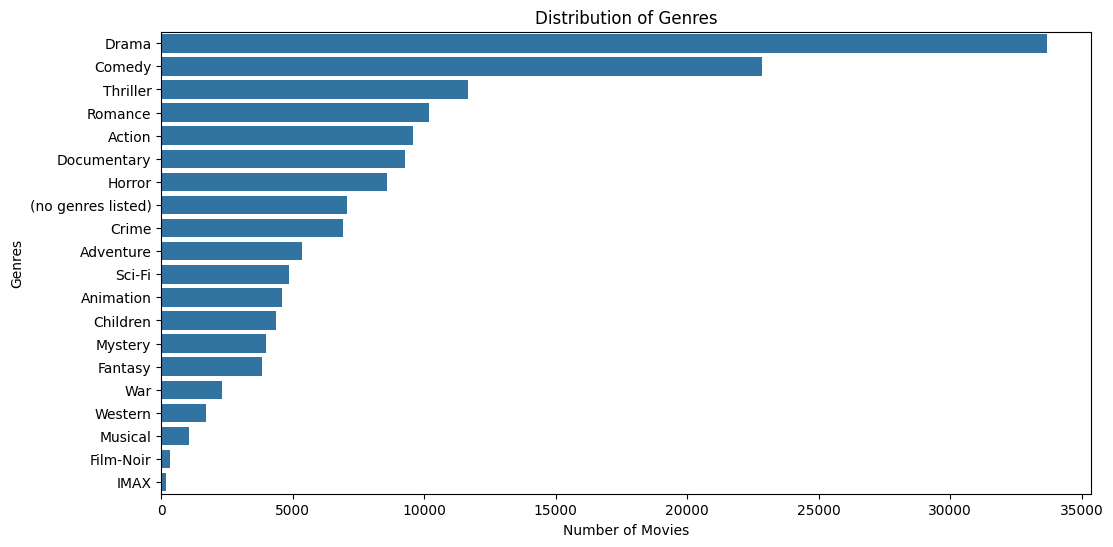

In [36]:
# Plotting 
plt.figure(figsize=(12,6))
sns.barplot(x=genres.values, y=genres.index)
plt.title("Distribution of Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genres")
plt.show()